In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from scipy.optimize import curve_fit
from scipy import special
import glob
import os
plt.style.use(['science','notebook','grid'])
import matplotlib.ticker as ticker

- $$ M = I^{0} T^{1} I^{1} $$
<br>
- $$ n_{0} = n_{air} $$
- $$ n_{1} = n_{Ti02} $$
- $$ n_{2} = n_{B270} $$

# Pas de couche

In [2]:
len0 = pd.read_csv('1re séance/lentille_0.txt',delimiter='\t',skiprows=17,names=['x','y'],decimal=',')
len0['x'] = len0['x'].apply(lambda x: x.replace(',','.'))
len0.drop(3648,inplace=True)
len0['y'] = len0['y'] / 350 #temps d'intégration
len0['x'] = len0['x'].apply(lambda x: float(x))

Text(0.5, 1.0, 'Spectre sans couche')

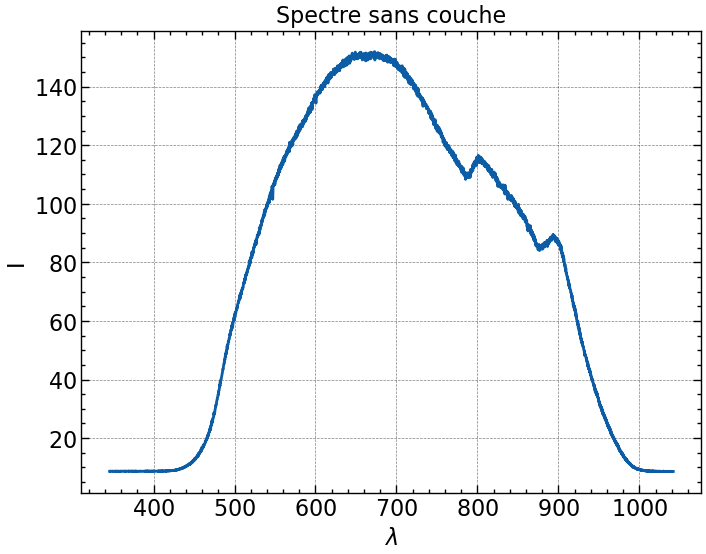

In [3]:
plt.plot(len0['x'],len0['y'])
plt.xlabel('$\lambda$')
plt.ylabel('I')
plt.title('Spectre sans couche')

# Couche 3

In [4]:
len3 = pd.read_csv('1re séance/lentille_3.txt',delimiter='\t',skiprows=17,names=['x','y'],decimal=',')
len3['x'] = len3['x'].apply(lambda x: x.replace(',','.'))
len3.drop(3648,inplace=True)
len3['y'] = len3['y'] / 350 #temps d'intégration
len3['x'] = len3['x'].apply(lambda x: float(x))

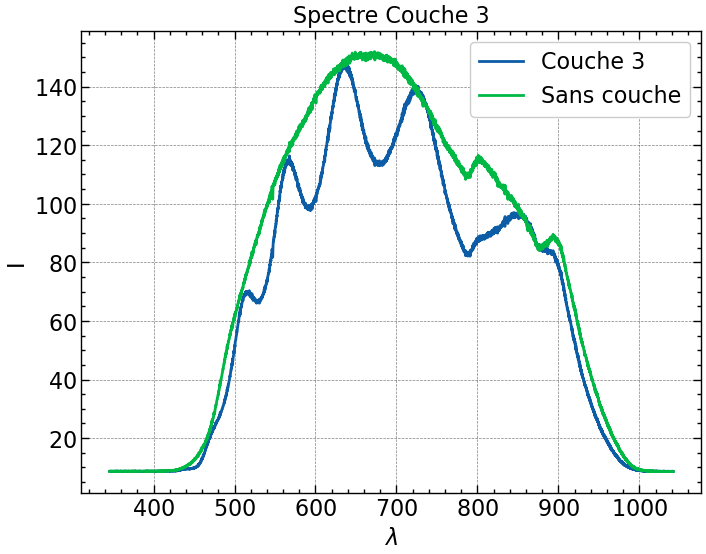

In [5]:
plt.plot(len3['x'],len3['y'],label='Couche 3')
plt.plot(len0['x'],len0['y'],label='Sans couche')
plt.xlabel('$\lambda$')
plt.ylabel('I')
plt.title('Spectre Couche 3')
plt.legend()

# Transmittance couche 3

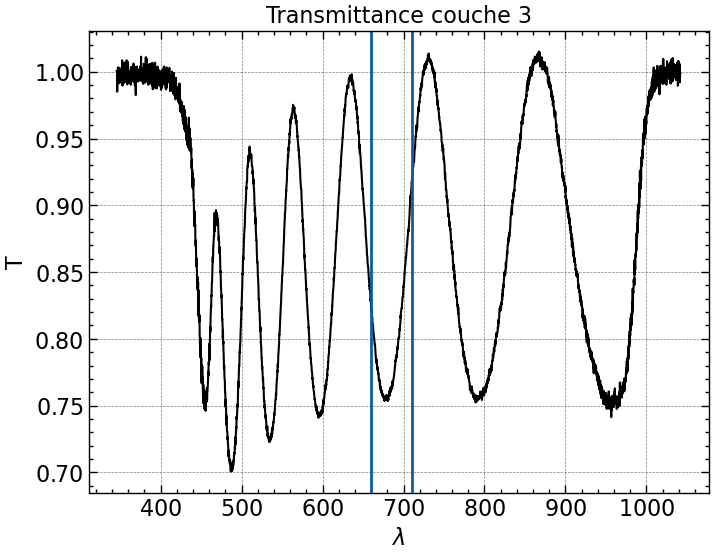

In [6]:
#Dataframe du spectre de transmittance
len3_T = pd.DataFrame(list(zip(len3['x'],len3['y']/len0['y'])),columns=['x','y'])
plt.plot(len3_T['x'],len3_T['y'],linewidth=1.5,color='black')
plt.xlabel('$\lambda$')
plt.ylabel('T')
plt.title('Transmittance couche 3')

#On définit la zone d'intérêt
plt.axvline(660,linewidth=2)
plt.axvline(710,linewidth=2)


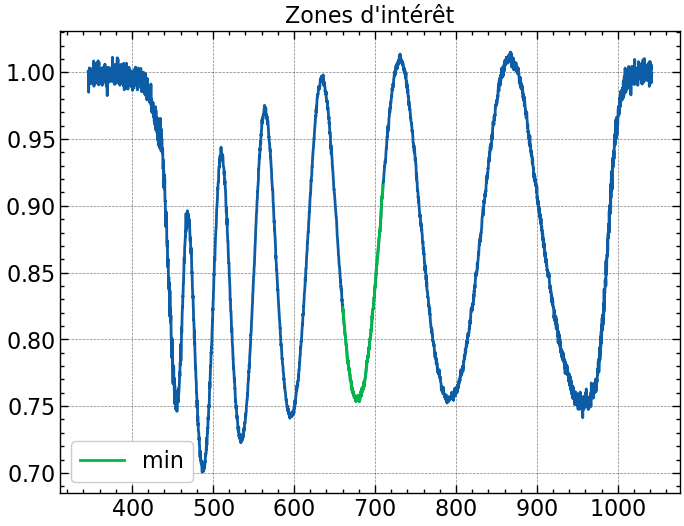

In [12]:
#Définir le dataframe de la zone qui nous intérêsse pour trouver la position du min
df_min = len3_T[(len3_T['x']>660) & (len3_T['x']<710)]

#min
min1 = float(df_min[df_min['y'] == np.min(df_min['y'])]['x'])

#Graphiquement
plt.plot(len3_T['x'],len3_T['y'])
plt.plot(df_min['x'],df_min['y'],label='min')
plt.title("Zones d'intérêt")
plt.legend()



### Approche Matricielle

- On utilise l'équation de Transmittance sur laquelle on loupe toutes les valeurs de lambda, içi len3['x'].
- Pour pouvoir voir plusieurs spèctres, il suffit de mettre une liste dans la loop for pour le d

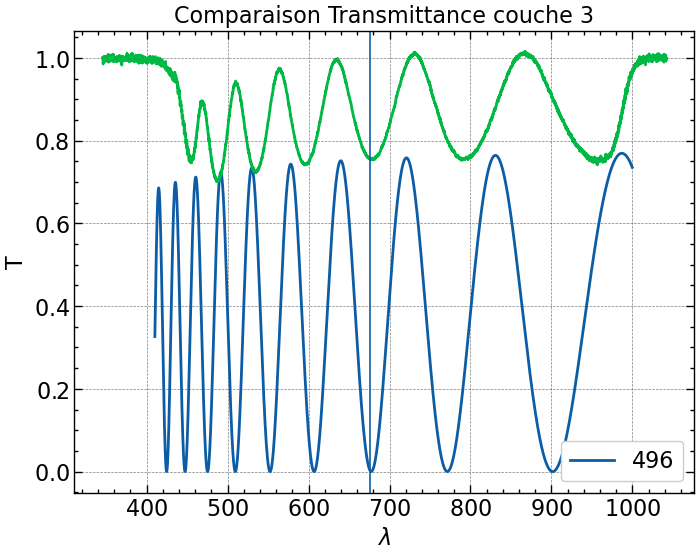

In [19]:
for d in [496]:
    Transmittance = []

    for lam in list(len3['x']) : #lambda en nm    
        #Nos coefficient de réfraction

        n0 = 1 - (0.057892105/(238.0185 - (lam*10**-3)**-2)) + 0.00167917/(57.362 - (lam*10**-3)**-2) #Air
        n1 = np.sqrt(5.913 + 0.2441/(((lam*10**-3)**2) - 0.0803)) #TiO2
        n2 = np.sqrt((1.676*lam**2)/(lam**2 - 99.19**2) + (0.3728*lam**2)/(lam**2-6.359**2) + (0.2172*lam**2)/(lam**2 - 6.436**2)) #B270

        #Matrice I0
        #Coefficient de frenels

        t0 = 2*n0/(n1 + n0)
        r0 = (n1 - n0)/(n1 + n0)

        I0 = np.array([
            [1/t0,r0/t0],
            [r0/t0,1/t0]
        ])

        #Matrice T1

        #d1 = 200*10**-9 #disons d = 250 nm
        delta = 4*np.pi*(d*10**-9)*n1/(lam*10**-9)

        T1 = np.array([
            [np.e**(-1j*delta),0],
            [0,np.e**(1j*delta)]
        ])

        #Matrice I1
        #Coefficient de frenels

        r1 = (n2 - n1)/(n2 + n1)
        t1 = 2*n1/(n2 + n1)

        I1 = np.array([
            [1/t1,r1/t1],
            [r1/t1,1/t1]
        ])

        #On ne orend que E+

        Ek = np.array([
            [1],
            [0]
        ])

        E0 = (I0*T1*I1*Ek)[0][0] #Prendre la donnée restante

        t = 1/E0

        T = (n2/n0) * np.real(t)**2
        R = np.real(t)**2
        Transmittance.append(T)
        
    #On fait un dataframe avec comme x les longeurs d'ondes utilisées pour l'itération et T la transmittance
    #On garde [410,1000] comme zone d'intérêt pour ne pas oveloard le graph
    
    df_T = pd.DataFrame(list(zip(len3['x'],Transmittance)),columns = ['x','y'])
    df_T = df_T[(df_T['x'] > 410) & (df_T['x'] < 1000)]
        
    plt.plot(df_T['x'],df_T['y'],label=d)
    plt.plot(len3_T['x'],len3_T['y'])
    plt.xlabel('$\lambda$')
    plt.ylabel('T')
    plt.title('Comparaison Transmittance couche 3')
    plt.legend()
    plt.axvline(min1,linewidth = 1.2) #On veut aligner les courbes autour du lambda d'intérêt, ici min1

# Comparaison couche 2 et 3

In [9]:
#df pour couche 2
len2 = pd.read_csv('1re séance/lentille_2.txt',delimiter='\t',skiprows=17,names=['x','y'],decimal=',')
len2['x'] = len2['x'].apply(lambda x: x.replace(',','.'))
len2.drop(3648,inplace=True)
len2['y'] = len2['y'] / 350 #temps d'intégration
len2['x'] = len2['x'].apply(lambda x: float(x))

#Transmittance couche 2
df_T2 = pd.read_excel('Transmittance 2.xlsx')

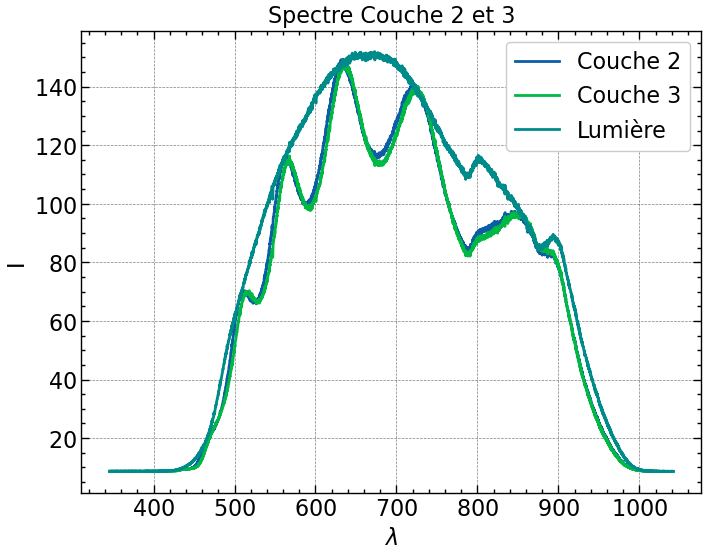

In [10]:
plt.plot(len2['x'],len2['y'],label='Couche 2')
plt.plot(len3['x'],len3['y'],label='Couche 3')
plt.plot(len0['x'],len0['y'],label='Lumière',color='darkcyan')
plt.xlabel('$\lambda$')
plt.ylabel('I')
plt.title('Spectre Couche 2 et 3')
plt.legend()

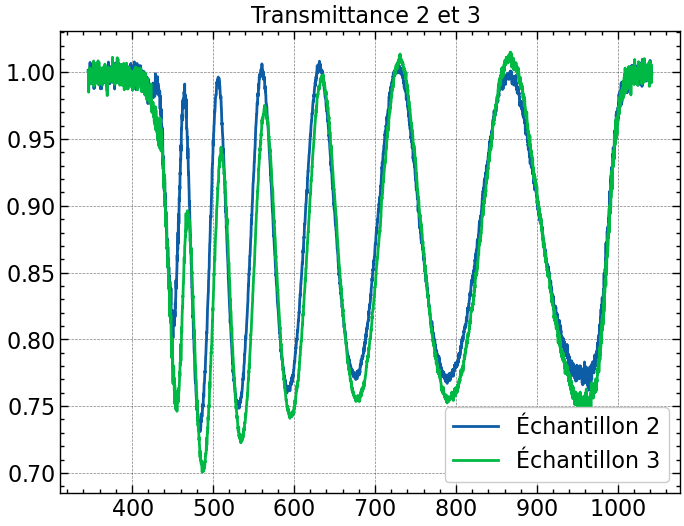

In [18]:
plt.plot(df_T2['x'],df_T2['y'],label='Échantillon 2')
plt.plot(len3_T['x'],len3_T['y'],label='Échantillon 3')
plt.title('Transmittance 2 et 3 ')
plt.legend()

Les deux spectre sont similaire au point qu'on trouve que les deux ont la même épaisseur